To get the mean or median NDVI by LULC or (LULC * TCC)

## Packages

In [230]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

from rasterio.mask import mask
from rasterio import mask as rio_mask
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.transform import array_bounds
from rasterstats import zonal_stats

from shapely.geometry import box
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import Normalize




# Set the working directory
wd = 'E:/_data/LULC/NLCD_USA/'
os.chdir(wd)


# Output directory
dir_output = 'D:/natcap/invest-mental-health/'
dir_lc     = 'D:/natcap/invest-mental-health/data/lc_scenarios'
dir_dat    = 'D:/natcap/invest-mental-health/data'
dir_fig    = 'D:/natcap/invest-mental-health/figs'

## Data

In [231]:

## aoi shapefile
aoi_path = os.path.join(dir_dat, 'cb_2019_us_county_500k_06075_clip.shp')

## land cover only 
lc_b_path = os.path.join(dir_lc, 'nlcd_2011_land_cover.tif')
lc_s_path = os.path.join(dir_lc, 'nlcd_2021_land_cover.tif')


## NDVI data
# ndvi_b_path = os.path.join(dir_dat, 'ndvi_s2_075_2019_10m_v2_prj.tif')
ndvi_b_path = os.path.join(dir_dat, 'NDVI_landsat_30m_06075_2011_median.tif')
ndvi_s_path = os.path.join(dir_dat, 'NDVI_landsat_30m_06075_2021_median.tif')


## land cover * tcc
# suffix = 'lc_tcc'
# lc_b_path = os.path.join('nlcd_2019_land_cover_l48_20210604', 'nlcd_2019_land_cover_l48_20210604_clipped_reclassified.tif')


### AOI

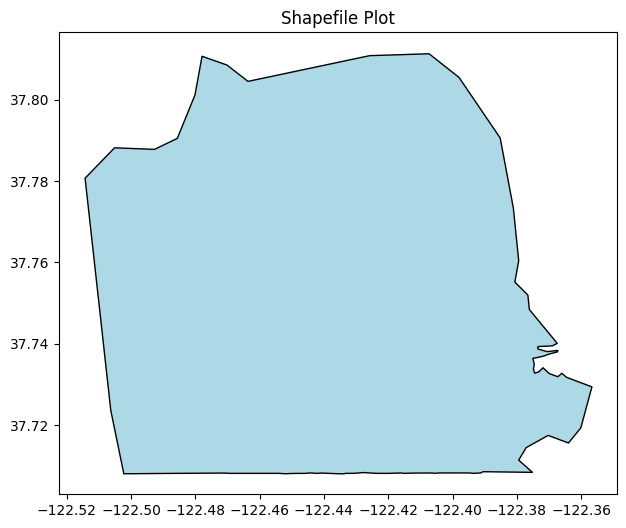

In [232]:
# Load the shapefile
aoi = gpd.read_file(aoi_path)

# Step 2: Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 6))
aoi.plot(ax=ax, color='lightblue', edgecolor='black')

# Customize plot
ax.set_title("Shapefile Plot")
plt.show()

### NDVI

Reprojecting city boundary from EPSG:4269 to EPSG:4326


C:\Users\pc\AppData\Local\Temp\ipykernel_30808\4008523725.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aoi_geometry = [aoi.geometry.unary_union]


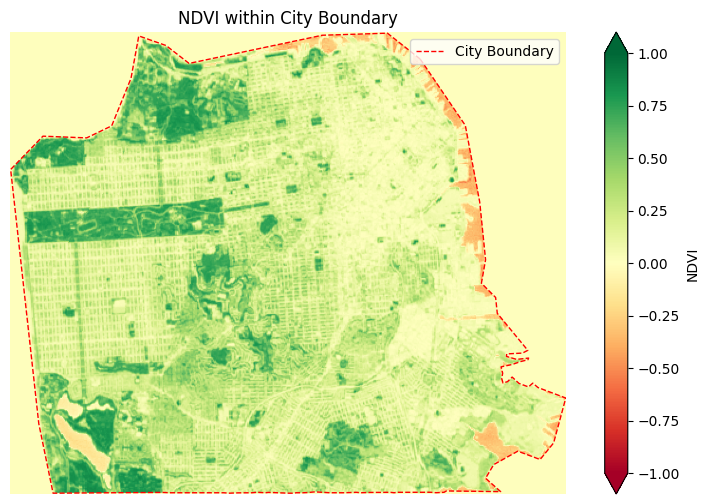

In [233]:
ndvi_f      = os.path.basename(ndvi_b_path).replace('.tif', '.png')
ndvi_figure = os.path.join(dir_fig, ndvi_f)

# Step 1: Load the NDVI raster

with rasterio.open(ndvi_b_path) as ndvi_src:
    ndvi = ndvi_src.read(1)
    ndvi_crs = ndvi_src.crs
    ndvi_meta = ndvi_src.meta


if aoi.crs != ndvi_crs:
    print(f"Reprojecting city boundary from {aoi.crs} to {ndvi_crs}")
    aoi = aoi.to_crs(ndvi_crs)


# Step 3: Clip the NDVI raster using the reprojected AOI
aoi_geometry = [aoi.geometry.unary_union]



with rasterio.open(ndvi_b_path) as src:
    ndvi_clipped, ndvi_clipped_transform = mask(src, aoi_geometry, crop=True)
    ndvi_clipped_meta = src.meta.copy()
    ndvi_clipped_meta.update({
        "driver": "GTiff",
        "height": ndvi_clipped.shape[1],
        "width": ndvi_clipped.shape[2],
        "transform": ndvi_clipped_transform
    })


# Step 6: Visualize the clipped NDVI with AOI and city boundary overlay
fig, ax = plt.subplots(figsize=(10, 6))
norm = Normalize(vmin=-1, vmax=1)
plt.imshow(ndvi_clipped[0], 
           cmap='RdYlGn', 
           norm=norm,
           extent=[
    ndvi_clipped_transform[2],  # x_min
    ndvi_clipped_transform[2] + ndvi_clipped_transform[0] * ndvi_clipped.shape[2],  # x_max
    ndvi_clipped_transform[5] + ndvi_clipped_transform[4] * ndvi_clipped.shape[1],  # y_min
    ndvi_clipped_transform[5]  # y_max
])
plt.colorbar(label='NDVI', extend='both')
aoi.boundary.plot(ax=ax, edgecolor='red', linewidth=1, linestyle='--', label='City Boundary')

# Customize the plot
ax.set_title('NDVI within City Boundary')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('off')
plt.legend()
plt.savefig(ndvi_figure, bbox_inches='tight', dpi=300)
plt.show()



## Process - NDVI by LULC

### Functions

In [234]:


def clip_raster(raster_path, boundary_geom, output_path=None):
    """Clip raster to boundary geometry (in same CRS)"""
    with rasterio.open(raster_path) as src:
        out_image, out_transform = rio_mask.mask(src, [boundary_geom], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        # Save the clipped raster if output_path is provided
        if output_path:
            with rasterio.open(output_path, "w", **out_meta) as dst:
                dst.write(out_image)

        return out_image.squeeze(), out_meta
    

def align_ndvi_to_nlcd(ndvi_path, nlcd_meta):
    """Reproject NDVI to match clipped NLCD's specifications"""
    with rasterio.open(ndvi_path) as src:
        ndvi_reprojected = np.zeros((nlcd_meta['height'], nlcd_meta['width']), dtype=np.float32)
        
        reproject(
            source=rasterio.band(src, 1),
            destination=ndvi_reprojected,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=nlcd_meta['transform'],
            dst_crs=nlcd_meta['crs'],
            resampling=Resampling.bilinear,
            dst_nodata=np.nan
        )
    return ndvi_reprojected

def calculate_mean_ndvi(ndvi, nlcd_data, nlcd_nodata):
    """Calculate mean NDVI for each NLCD class present in the data"""
    # Get all unique NLCD classes (excluding nodata)
    valid_classes = np.unique(nlcd_data[(nlcd_data != nlcd_nodata) & (nlcd_data > 0)])
    
    # Calculate mean NDVI for each class
    results = {}
    for cls in valid_classes:
        mask = (nlcd_data == cls) & (~np.isnan(ndvi))
        if np.any(mask):
            results[cls] = np.nanmean(ndvi[mask])
        else:
            results[cls] = np.nan  # Class exists but has no valid NDVI
    return results


In [235]:

def process_nlcd_with_ndvi(aoi_file, nlcd_file, ndvi_file, clipped_nlcd_output):
    """
    Process a single NLCD file to compute mean NDVI by land cover type.

    Parameters:
    - aoi_file: path to the boundary shapefile or GeoJSON.
    - nlcd_file: path to the NLCD raster file.
    - ndvi_file: path to the NDVI raster file.
    - clipped_nlcd_output: path to save the clipped NLCD raster (GeoTIFF).
  
    """
    # 1. Load and project boundary geometry
    boundary_gdf = gpd.read_file(aoi_file)
    with rasterio.open(nlcd_file) as nlcd_src:
        boundary_proj = boundary_gdf.to_crs(nlcd_src.crs)
        boundary_geom = boundary_proj.geometry.values[0]

    # 2. Clip NLCD to boundary
    clipped_nlcd, nlcd_meta = clip_raster(nlcd_file, boundary_geom, output_path=clipped_nlcd_output)
    nlcd_nodata = nlcd_meta.get('nodata', 0)

   
    # 3. Align and clip NDVI
    ndvi_aligned = align_ndvi_to_nlcd(ndvi_file, nlcd_meta)

    # 4. Calculate mean NDVI for each NLCD class
    mean_ndvi = calculate_mean_ndvi(ndvi_aligned, clipped_nlcd, nlcd_nodata)

    # 5. Export results to CSV
    output_df = pd.DataFrame({
        'NLCD_Code': list(mean_ndvi.keys()),
        'Mean_NDVI': list(mean_ndvi.values())
    }).sort_values('NLCD_Code')


    


    ## Save the results to CSV
    output_csv   = os.path.join(dir_dat, 'mean_ndvi_by_' + os.path.basename(nlcd_file).replace('tif', 'csv').replace('_land_cover', '') ); 
    # print(output_csv)

    output_df.to_csv(output_csv, index=False)
    print(f"NDVI by LC   saved to {output_csv}")
    print(f"Clipped NLCD saved to {clipped_nlcd_output}")
    return output_df


### Run data

In [236]:
## baseline
df = process_nlcd_with_ndvi(
    aoi_file   = aoi_path,
    nlcd_file  = lc_b_path,
    ndvi_file  = ndvi_b_path,
    clipped_nlcd_output=lc_b_path.replace('.tif', '_clipped.tif')
)


## scenario 
df = process_nlcd_with_ndvi(
    aoi_file   = aoi_path,
    nlcd_file  = lc_s_path,
    ndvi_file  = ndvi_s_path,
    clipped_nlcd_output=lc_s_path.replace('.tif', '_clipped.tif')
)


NDVI by LC   saved to D:/natcap/invest-mental-health/data\mean_ndvi_by_nlcd_2011.csv
Clipped NLCD saved to D:/natcap/invest-mental-health/data/lc_scenarios\nlcd_2011_land_cover_clipped.tif
NDVI by LC   saved to D:/natcap/invest-mental-health/data\mean_ndvi_by_nlcd_2021.csv
Clipped NLCD saved to D:/natcap/invest-mental-health/data/lc_scenarios\nlcd_2021_land_cover_clipped.tif


# Functions

## Generate NDVI by LC raster

In [241]:
import os
import geopandas as gpd
import rasterio
import pandas as pd
import numpy as np

def generate_ndvi_by_nlcd_raster(lc_path, aoi_path, ndvi_lc_csv, output_dir, exclude_classes=[11, 12, 90, 95]):
    """
    Generates a raster where each NLCD class is assigned its mean NDVI value (excluding certain classes),
    and saves it as a GeoTIFF.
    """
    lc_clipped = lc_path.replace('.tif', '_clipped.tif')
    boundary_gdf = gpd.read_file(aoi_path)

    with rasterio.open(lc_clipped) as src:
        nlcd_meta = src.meta
        clipped_nlcd = src.read(1)
        boundary_proj = boundary_gdf.to_crs(src.crs)

    # Load NDVI mean values
    mean_ndvi_df = pd.read_csv(ndvi_lc_csv)
    mean_ndvi = dict(zip(mean_ndvi_df['NLCD_Code'], mean_ndvi_df['Mean_NDVI']))

    # Initialize output array
    ndvi_by_nlcd = np.full_like(clipped_nlcd, np.nan, dtype=np.float32)

    # Assign mean NDVI to each NLCD class except excluded ones
    for nlcd_class, mean_val in mean_ndvi.items():
        if nlcd_class not in exclude_classes:
            ndvi_by_nlcd[clipped_nlcd == nlcd_class] = mean_val

    # Set nodata
    ndvi_by_nlcd = np.where(np.isnan(ndvi_by_nlcd), -9999, ndvi_by_nlcd)

    # Update metadata
    ndvi_meta = nlcd_meta.copy()
    ndvi_meta.update({
        "dtype": "float32",
        "count": 1,
        "nodata": -9999
    })

    # Save the raster
    f = os.path.basename(lc_path).replace('_land_cover', '')
    output_path = os.path.join(output_dir, "ndvi_by_" + f)
    with rasterio.open(output_path, "w", **ndvi_meta) as dst:
        dst.write(ndvi_by_nlcd, 1)

    print(f"New raster saved: {output_path}")
    return output_path, boundary_proj, ndvi_by_nlcd, ndvi_meta



# ## extract the year from the filename
# import re

# def extract_year_from_filename(filename):
#     """Extract 4-digit year from a file name (e.g., 'land_cover_2021.tif')."""
#     match = re.search(r'20\d{2}|19\d{2}', filename)
#     return match.group(0) if match else 'unknown'



## Visualize the NDVI-by-NLCD Raster

In [244]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from rasterio.transform import array_bounds

def visualize_ndvi_raster(ndvi_array, meta, boundary_proj, output_image_path, title="Mean NDVI per NLCD Type"):
    """
    Visualizes an NDVI-by-NLCD raster with AOI boundary and saves the figure as a PNG.
    """
    transform = meta['transform']
    height, width = meta['height'], meta['width']
    left, bottom, right, top = array_bounds(height, width, transform)

    fig, ax = plt.subplots(figsize=(10, 6))
    norm = Normalize(vmin=-0.8, vmax=0.8)
    img = ax.imshow(ndvi_array, cmap='RdYlGn', norm=norm,
                    extent=[left, right, bottom, top], origin='upper')

    boundary_proj.boundary.plot(ax=ax, edgecolor='black',
                                 linewidth=0.5, linestyle='--', label='AOI Boundary')

    cbar = plt.colorbar(img, ax=ax, extend='both')
    cbar.set_label('Mean NDVI', rotation=270, labelpad=14)
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.axis('off')

    plt.savefig(output_image_path, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"Map saved to: {output_image_path}")


## Run and Viz NDVI-by-NLCD raster

New raster saved: D:/natcap/invest-mental-health/ndvi_by_nlcd_2011.tif


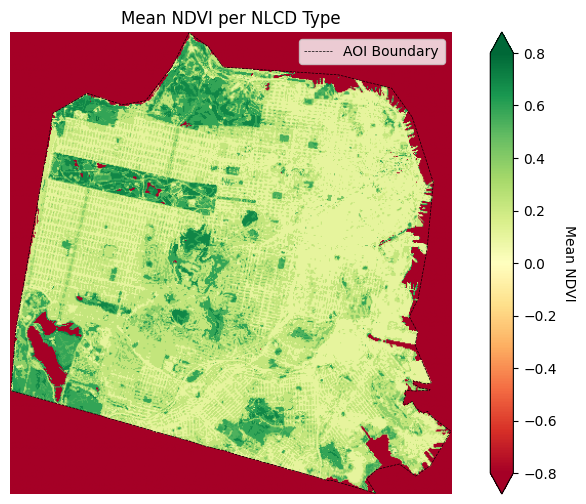

Map saved to: D:/natcap/invest-mental-health/figs\mean_ndvi_by_nlcd_2011.png
New raster saved: D:/natcap/invest-mental-health/ndvi_by_nlcd_2021.tif


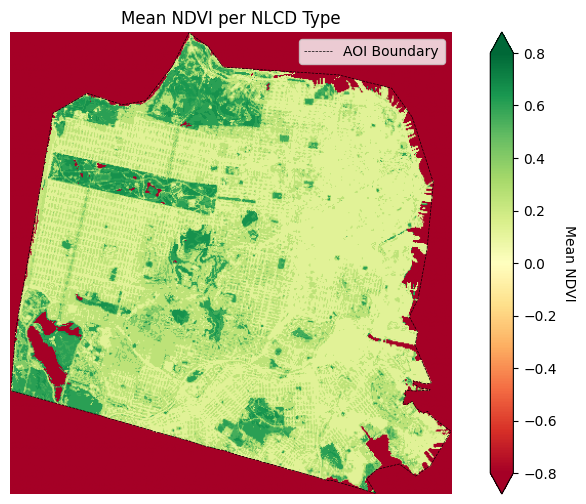

Map saved to: D:/natcap/invest-mental-health/figs\mean_ndvi_by_nlcd_2021.png


In [245]:
## baseline ----------------------------------------------------------------------------
output_csv = os.path.join(dir_dat, 'mean_ndvi_by_nlcd_2011.csv')
output_fig = os.path.join(dir_fig, 'mean_ndvi_by_nlcd_2011.png')

# Step 1: Generate the NDVI-by-NLCD raster
raster_path, boundary_proj, ndvi_array, ndvi_meta = generate_ndvi_by_nlcd_raster(
    lc_path = lc_b_path, 
    aoi_path = aoi_path, 
    ndvi_lc_csv = output_csv, 
    output_dir = dir_output
)

# Step 2: Visualize the raster
visualize_ndvi_raster(ndvi_array, ndvi_meta, boundary_proj, output_fig)




## scenario ----------------------------------------------------------------------------
output_csv = os.path.join(dir_dat, 'mean_ndvi_by_nlcd_2021.csv')
output_fig = os.path.join(dir_fig, 'mean_ndvi_by_nlcd_2021.png')

# Step 1: Generate the NDVI-by-NLCD raster
raster_path, boundary_proj, ndvi_array, ndvi_meta = generate_ndvi_by_nlcd_raster(
    lc_path = lc_s_path, 
    aoi_path = aoi_path, 
    ndvi_lc_csv = output_csv, 
    output_dir = dir_output
)

# Step 2: Visualize the raster
visualize_ndvi_raster(ndvi_array, ndvi_meta, boundary_proj, output_fig)


# Difference of NDVI between two scenarios

In [246]:

# Paths to input rasters
ndvi_2011_path = os.path.join(dir_lc, "ndvi_by_nlcd_2011.tif"); 
ndvi_2021_path = os.path.join(dir_lc, "ndvi_by_nlcd_2021.tif");
ndvi_diff_path = os.path.join(dir_lc, "ndvi_change_scenario_minus_baseline.tif")

# 1. Open both rasters
with rasterio.open(ndvi_2011_path) as src_2011, rasterio.open(ndvi_2021_path) as src_2021:
    ndvi_2011 = src_2011.read(1).astype(np.float32)
    ndvi_2021 = src_2021.read(1).astype(np.float32)
    meta = src_2011.meta.copy()
    nodata = meta.get('nodata', -9999)

# 2. Handle nodata masks
mask = (ndvi_2011 == nodata) | (ndvi_2021 == nodata)
ndvi_diff = ndvi_2021 - ndvi_2011
ndvi_diff[mask] = nodata  # Set change to nodata where original pixels were nodata

# 3. Update metadata
meta.update({
    "dtype": "float32",
    "nodata": nodata
})

# 4. Save the NDVI difference raster
with rasterio.open(ndvi_diff_path, 'w', **meta) as dst:
    dst.write(ndvi_diff, 1)

print(f"NDVI change raster saved to: {ndvi_diff_path}")


NDVI change raster saved to: D:/natcap/invest-mental-health/data/lc_scenarios\ndvi_change_scenario_minus_baseline.tif


## Plot

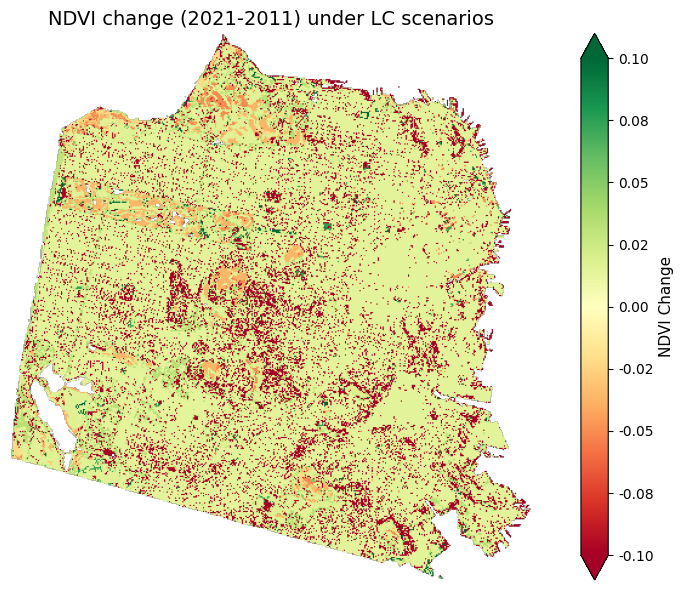

In [247]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FormatStrFormatter
import numpy as np

# Load NDVI difference raster
with rasterio.open(ndvi_diff_path) as src:
    ndvi_diff = src.read(1)
    ndvi_meta = src.meta
    ndvi_bounds = src.bounds

# Mask no-data for visualization
nodata = ndvi_meta.get('nodata', -9999)
ndvi_masked = np.ma.masked_equal(ndvi_diff, nodata)


# Compute min and max excluding nodata
actual_min = ndvi_masked.min()
actual_max = ndvi_masked.max()

# Ensure color map is centered at 0
max_abs = max(abs(actual_min), abs(actual_max))
vmin, vmax = -max_abs, max_abs


# # Set up diverging colormap centered at 0 (no change)
# vmin, vmax = -0.5, 0.5  # Adjust based on your data range
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot
plt.figure(figsize=(10, 6))
img = plt.imshow(ndvi_masked, cmap='RdYlGn', norm=norm)
cbar = plt.colorbar(img, extend='both')
cbar.set_label("NDVI Change", fontsize=11)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # <-- Format tick labels to 2 decimals
plt.title("NDVI change (2021-2011) under LC scenarios", fontsize=14)
plt.axis('off')
plt.tight_layout()

# Save figure as PNG
output_png = os.path.join(dir_fig, "ndvi_change_2021_minus_2011.png")
plt.savefig(output_png, dpi=300, bbox_inches='tight')

plt.show()
